In [30]:
# import packages
import os
import csv
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf

In [31]:
import pandas as pd 

train_df = pd.read_csv('../../tensorflow_datasets/handwritten-digits/data/training_data.csv', header=None)
test_df = pd.read_csv('../../tensorflow_datasets/handwritten-digits/data/test_data.csv', header=None)

columns = ['img_name', 'label', 'x1', 'y1', 'x2', 'y2']
train_df.columns = columns
test_df.columns = columns

train_df.head()

,img_name,label,x1,y1,x2,y2
0,converted_training1.png,4,0.49,0.15,0.77,0.43
1,converted_training2.png,1,0.64,0.26,0.92,0.54
2,converted_training3.png,0,0.42,0.39,0.70,0.67
3,converted_training4.png,7,0.58,0.10,0.86,0.38
4,converted_training5.png,8,0.21,0.23,0.49,0.51


In [32]:
train_image_names = train_df.img_name.values
train_labels = train_df.label.values
train_bbox = train_df[['x1', 'y1', 'x2', 'y2']].values

test_image_names = test_df.img_name.values
test_labels = test_df.label.values
test_bbox = test_df[['x1', 'y1', 'x2', 'y2']].values

In [33]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
TRAIN_IMG_PATH = '../../tensorflow_datasets/handwritten-digits/data/MNIST_Converted_Training/'
TEST_IMG_PATH = '../../tensorflow_datasets/handwritten-digits/data/MNIST_Converted_Testing/'

@tf.function
def preprocess_train(image_name, label, bbox):
    image = tf.io.read_file(TRAIN_IMG_PATH+image_name)
    image = tf.image.decode_png(image, channels=1)

    return image, {'label': label, 'bbox': bbox}

@tf.function
def preprocess_test(image_name, label, bbox):
    image = tf.io.read_file(TEST_IMG_PATH+image_name)
    image = tf.image.decode_png(image, channels=1)

    return image, {'label': label, 'bbox': bbox}

trainloader = tf.data.Dataset.from_tensor_slices((train_image_names, train_labels, train_bbox))
testloader = tf.data.Dataset.from_tensor_slices((test_image_names, test_labels, test_bbox))

trainloader = (
    trainloader
    .map(preprocess_train, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [34]:
def show_batch(image_batch, label_batch, bbox):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      img = np.squeeze(image_batch[n], axis=-1)
      img = cv2.rectangle(img,(bbox[n][0],bbox[n][1]),(bbox[n][2],bbox[n][3]),(255,0,0),2)
      plt.imshow(img, cmap='gray')
      plt.title(label_batch[n])
      plt.axis('off')

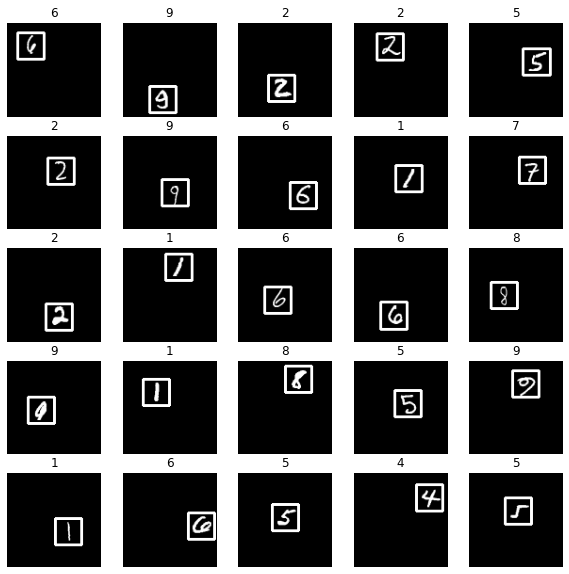

In [35]:
img_samples, label_bbox = next(iter(trainloader))
img_samples.shape, label_bbox['label'].shape, label_bbox['bbox'].shape

show_batch(img_samples, label_bbox['label'].numpy(), (label_bbox['bbox'].numpy()*100).astype('int32'))

In [36]:
inputs = layers.Input(shape=(100,100,1))
# add layer 
x = layers.Conv2D(32, (3,3), strides=(1, 1), padding='valid')(inputs)
# add max pooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# add layer
x = layers.Conv2D(32,(3,3), strides=(1, 1), padding='valid')(x)
# add max pooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# add max pooling
x = layers.Conv2D(64, (3,3), strides=(1, 1), padding='valid')(x)
# add max pooling
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# flatten
x = layers.GlobalAveragePooling2D()(x)
# Add a dropout rate of 0.2
image_classifieer = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
image_classifier = layers.Dense(10, activation='softmax',  name='label')(image_classifieer)   

bbox_label = layers.Dense(64, activation='relu')(x)
bbox_label = layers.Dense(32, activation='relu')(bbox_label )
bbox_label = layers.Dense(4, activation='sigmoid', name='bbox')(bbox_label)
model = Model(inputs=[inputs], outputs=[image_classifier, bbox_label ])
model.summary()




Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 98, 98, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 49, 49, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 47, 47, 32)   9248        max_pooling2d_21[0][0]           
____________________________________________________________________________________________

In [37]:
losses = {'label': 'sparse_categorical_crossentropy',
          'bbox': 'mse'}

loss_weights = {'label': 1.0,
                'bbox': 1.0}

model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])

In [38]:
model.fit(trainloader,
          epochs=10,
          validation_data=testloader)

Epoch 1/10
1875/1875 [==============================] - 348s 185ms/step - loss: 0.9688 - label_loss: 0.9339 - bbox_loss: 0.0349 - label_acc: 0.6886 - bbox_acc: 0.6167 - val_loss: 0.1953 - val_label_loss: 0.1693 - val_bbox_loss: 0.0260 - val_label_acc: 0.9485 - val_bbox_acc: 0.6966
Epoch 2/10
1875/1875 [==============================] - 350s 187ms/step - loss: 0.2474 - label_loss: 0.2224 - bbox_loss: 0.0250 - label_acc: 0.9330 - bbox_acc: 0.7017 - val_loss: 0.1527 - val_label_loss: 0.1288 - val_bbox_loss: 0.0240 - val_label_acc: 0.9587 - val_bbox_acc: 0.7033
Epoch 3/10
1875/1875 [==============================] - 361s 193ms/step - loss: 0.1875 - label_loss: 0.1643 - bbox_loss: 0.0232 - label_acc: 0.9503 - bbox_acc: 0.7132 - val_loss: 0.1274 - val_label_loss: 0.1050 - val_bbox_loss: 0.0225 - val_label_acc: 0.9660 - val_bbox_acc: 0.7198
Epoch 4/10
1875/1875 [==============================] - 359s 191ms/step - loss: 0.1607 - label_loss: 0.1386 - bbox_loss: 0.0221 - label_acc: 0.9587 - bbox